<a href="https://colab.research.google.com/github/c90x/loan_prediction/blob/main/loan_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Dataset - Lab

## Dependencies

In [2]:
import re
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Configure theme

In [4]:
plt.style.use("dark_background")

**Download** dataset from Kaggle

In [5]:
import kagglehub

# Download latest version
path = Path(kagglehub.dataset_download("ranadeep/credit-risk-dataset"))

path = path / "loan" / "loan.csv"

assert path.exists()
assert path.is_file()

print("Downloaded dataset to path:", path)

/home/cube/source/dhbw/loan/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded dataset to path: /home/cube/.cache/kagglehub/datasets/ranadeep/credit-risk-dataset/versions/3/loan/loan.csv


Load dataset

In [6]:
df = pd.read_csv(path)
df = df.sample(n=80000, random_state=99)

/tmp/ipykernel_8595/2060233302.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


## Preprocessing

In [7]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

Select columns

In [8]:
df_select = [
    "loan_status",  # e
    #
    "addr_state",
    "annual_inc",
    "annual_inc_joint",
    #'application_type',
    "collection_recovery_fee",
    "collections_12_mths_ex_med",
    "dti",
    "dti_joint",
    "earliest_cr_line",  # d
    "emp_length",  # e
    #'fico_range_high',
    #'fico_range_low',
    #'grade',
    "home_ownership",  # e
    #'is_inc_v',
    "issue_d",  # d
    #'last_fico_range_high',
    #'last_fico_range_low',
    "loan_amnt",
    "open_acc",
    "pub_rec",
    "purpose",
    "recoveries",  #!!!
    "sub_grade",  # e
    "verification_status",  # e
    #'verified_status_joint',
    "zip_code",  # e
    "open_acc_6m",
    "open_il_6m",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "all_util",
    "total_rev_hi_lim",
    #'inq_fi',
    #'total_cu_tl',
    #'inq_last_12m',
    "acc_now_delinq",
    "tot_coll_amt",
    "tot_cur_bal",
]

df = df[df_select]

In [9]:
df.columns

Index(['loan_status', 'addr_state', 'annual_inc', 'annual_inc_joint',
       'collection_recovery_fee', 'collections_12_mths_ex_med', 'dti',
       'dti_joint', 'earliest_cr_line', 'emp_length', 'home_ownership',
       'issue_d', 'loan_amnt', 'open_acc', 'pub_rec', 'purpose', 'recoveries',
       'sub_grade', 'verification_status', 'zip_code', 'open_acc_6m',
       'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal'],
      dtype='object')

List **numerical data**

In [10]:
df.select_dtypes(include=[np.number]).columns.tolist()

['annual_inc',
 'annual_inc_joint',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'dti',
 'dti_joint',
 'loan_amnt',
 'open_acc',
 'pub_rec',
 'recoveries',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal']

List **non numerical data**

In [11]:
df.select_dtypes(include=["object"]).columns.tolist()

['loan_status',
 'addr_state',
 'earliest_cr_line',
 'emp_length',
 'home_ownership',
 'issue_d',
 'purpose',
 'sub_grade',
 'verification_status',
 'zip_code']

Encode `loan_status` and remove rows containing "Issued"

In [12]:
df["loan_status"].value_counts()

loan_status
Current                                                54212
Fully Paid                                             18753
Charged Off                                             4066
Late (31-120 days)                                      1063
Issued                                                   759
In Grace Period                                          567
Late (16-30 days)                                        211
Does not meet the credit policy. Status:Fully Paid       192
Default                                                  109
Does not meet the credit policy. Status:Charged Off       68
Name: count, dtype: int64

In [13]:
df = df[df["loan_status"].str.lower() != "issued"]

In [14]:
# loan_target:
# 0: bad
# 1: good

df_loan_status_good = [
    "current",
    "fully paid",
    "in grace period",
]


def df_loan_status_map(x):
    return 1 if x.lower() in df_loan_status_good else 0


df["loan_target"] = df["loan_status"].map(df_loan_status_map).fillna(0)

In [15]:
df.drop("loan_status", axis=1, inplace=True)

Target encode `addr_state`

In [16]:
# Calculate the mean of the target variable for each state
df_state_target_mean = df.groupby("addr_state")["loan_target"].mean()

# Map these means back to the original dataframe
df["addr_state"] = df["addr_state"].map(df_state_target_mean)

Map timespan between `earliest_cr_line` and `issue_d`

In [17]:
df_date_columns = ["issue_d", "earliest_cr_line"]
for col in df_date_columns:
    df[col] = pd.to_datetime(df[col], format="%b-%Y")

In [18]:
df["earliest_cr_line_timespan"] = df["issue_d"] - df["earliest_cr_line"]
df["earliest_cr_line_timespan"] = df["earliest_cr_line_timespan"].dt.days / 365.25

In [19]:
df.drop(df_date_columns, axis=1, inplace=True)

Encode `emp_length`

In [20]:
df["emp_length"].unique()

array(['1 year', '10+ years', '2 years', '7 years', '9 years', '6 years',
       nan, '8 years', '3 years', '5 years', '< 1 year', '4 years'],
      dtype=object)

In [21]:
def df_emp_length_map(s):
    if s.lower() == "< 1 year":
        return 0

    m = re.search(r"\d+", s)
    return int(m.group()) if m else 0


df["emp_length"] = df["emp_length"].map(df_emp_length_map, na_action="ignore").fillna(0)

One hot encode `home_ownership`

In [22]:
df = pd.get_dummies(df, columns=["home_ownership"], drop_first=True)

Target encode `purpose`

In [23]:
# Calculate the mean of the target variable for each category in the 'purpose' column
df_purpose_target_mean = df.groupby("purpose")["loan_target"].mean()

# Map these means back to the originissue_dal dataframe
df["purpose"] = df["purpose"].map(df_purpose_target_mean)

Encode `subgrade`

In [24]:
df["sub_grade"].unique()

array(['B3', 'A4', 'C2', 'C5', 'B5', 'D3', 'B4', 'C3', 'E1', 'E2', 'A2',
       'C4', 'E3', 'B2', 'D5', 'E4', 'A1', 'D1', 'C1', 'A5', 'A3', 'D2',
       'B1', 'D4', 'E5', 'F1', 'F3', 'F5', 'G4', 'F2', 'G3', 'F4', 'G1',
       'G2', 'G5'], dtype=object)

In [25]:
def df_sub_grade_map(s):
    return (ord(s[0]) - ord("A") + 1) + (int(s[1]) - 1) / 5


df["sub_grade"] = df["sub_grade"].map(df_sub_grade_map)

One hot encode `verification_status`

In [26]:
df = pd.get_dummies(df, columns=["verification_status"], drop_first=True)

Encode `zip_code`

In [27]:
# Extract the first two digits of the zip code
df["zip_code_group"] = df["zip_code"].apply(lambda x: x[:2])

# Calculate the mean of the target variable for each zip code group
df_zip_code_target_mean = df.groupby("zip_code_group")["loan_target"].mean()

# Map these means back to the original dataframe
df["zip_code"] = df["zip_code_group"].map(df_zip_code_target_mean)

# Drop the temporary zip_code_group column
df.drop("zip_code_group", axis=1, inplace=True)

In [28]:
df["zip_code"].head()

38778     0.939884
225599    0.928846
214742    0.932598
429826    0.945736
282590    0.918584
Name: zip_code, dtype: float64

Mark missing

In [29]:
for c in [
    "open_acc_6m",
    "open_il_6m",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "all_util",
    "total_rev_hi_lim",
]:
    df[f"{c}_m"] = df[c].apply(lambda x: 0 if pd.isna(x) else 1)

Fill missing

In [30]:
def df_fillna_with_median(c):
    df.fillna({c: df[c].median()}, inplace=True)


def df_fillna_with_median_of_loan(c):
    median_good = df[df["loan_target"] == 1][c].median()
    median_bad = df[df["loan_target"] == 0][c].median()

    for index, row in df[df[c].isnull()].iterrows():
        if row["loan_target"] == 1:
            df.at[index, c] = median_good
        else:
            df.at[index, c] = median_bad

In [31]:
df_fillna_with_median_of_loan("annual_inc")
df.fillna({"annual_inc_joint": 0}, inplace=True)
assert df["collection_recovery_fee"].isnull().sum() == 0
df.fillna({"collections_12_mths_ex_med": 0}, inplace=True)
assert df["dti"].isnull().sum() == 0
df.fillna({"dti_joint": 0}, inplace=True)
assert df["loan_amnt"].isnull().sum() == 0
df_fillna_with_median_of_loan("open_acc")
df.fillna({"pub_rec": 0}, inplace=True)
assert df["recoveries"].isnull().sum() == 0
df_fillna_with_median_of_loan("earliest_cr_line_timespan")
df.fillna({"open_acc_6m": -1}, inplace=True)  # m
df.fillna({"open_il_6m": -1}, inplace=True)  # m
df.fillna({"open_il_12m": -1}, inplace=True)  # m
df.fillna({"open_il_24m": -1}, inplace=True)  # m
df.fillna({"mths_since_rcnt_il": -1}, inplace=True)  # m
df.fillna({"total_bal_il": -1}, inplace=True)  # m
df.fillna({"il_util": -1}, inplace=True)  # m
df.fillna({"open_rv_12m": -1}, inplace=True)  # m
df.fillna({"open_rv_24m": -1}, inplace=True)  # m
df.fillna({"max_bal_bc": -1}, inplace=True)  # m
df.fillna({"all_util": -1}, inplace=True)  # m
df.fillna({"total_rev_hi_lim": 0}, inplace=True)
df_fillna_with_median("acc_now_delinq")
df_fillna_with_median_of_loan("tot_coll_amt")
df_fillna_with_median_of_loan("tot_cur_bal")

Mark missing and delete

In [32]:
def df_mark(columns):
    for c in columns:
        df[f"{c}_m"] = df[c].apply(lambda x: 0 if pd.isna(x) else 1)


df_mark([])

Print columns with incomplete values

In [33]:
print(df.columns[df.isnull().any()].tolist())

[]


Ensure all cells are valid

In [34]:
assert df.isnull().sum().sum() == 0, "DataFrame contains NaN values"

## Analysis

Amount of good vs bad loans

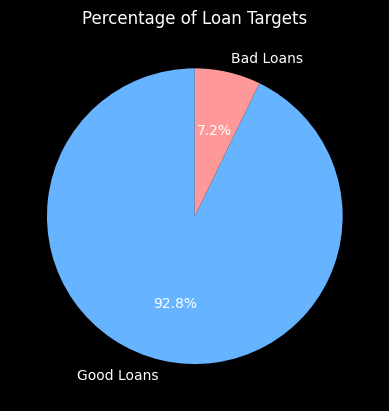

In [35]:
loan_target_counts = df["loan_target"].value_counts(normalize=True) * 100
loan_target_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Good Loans", "Bad Loans"],
    colors=["#66b3ff", "#ff9999"],
    startangle=90,
)
plt.title("Percentage of Loan Targets")
plt.ylabel("")
plt.show()

Percentage of good / bad loans by state

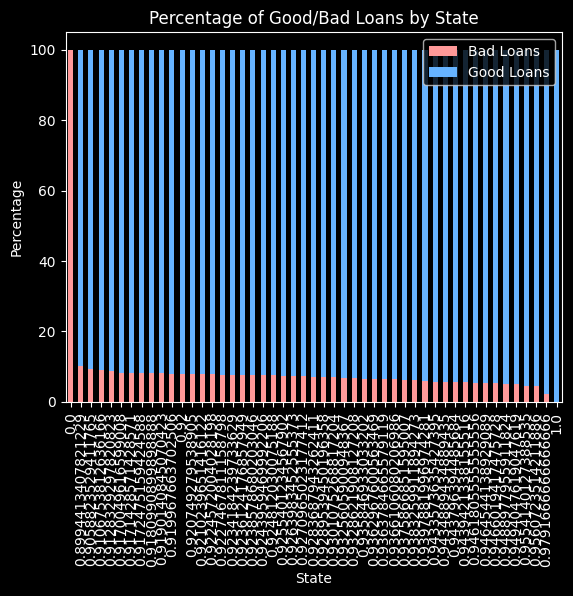

In [36]:
# Calculate the percentage of good/bad loans by state
state_loan_target = (
    df.groupby("addr_state")["loan_target"].value_counts(normalize=True).unstack() * 100
)

# Plot the bar plot
state_loan_target.plot(kind="bar", stacked=True, color=["#ff9999", "#66b3ff"])
plt.title("Percentage of Good/Bad Loans by State")
plt.xlabel("State")
plt.ylabel("Percentage")
plt.legend(["Bad Loans", "Good Loans"], loc="upper right")
plt.show()

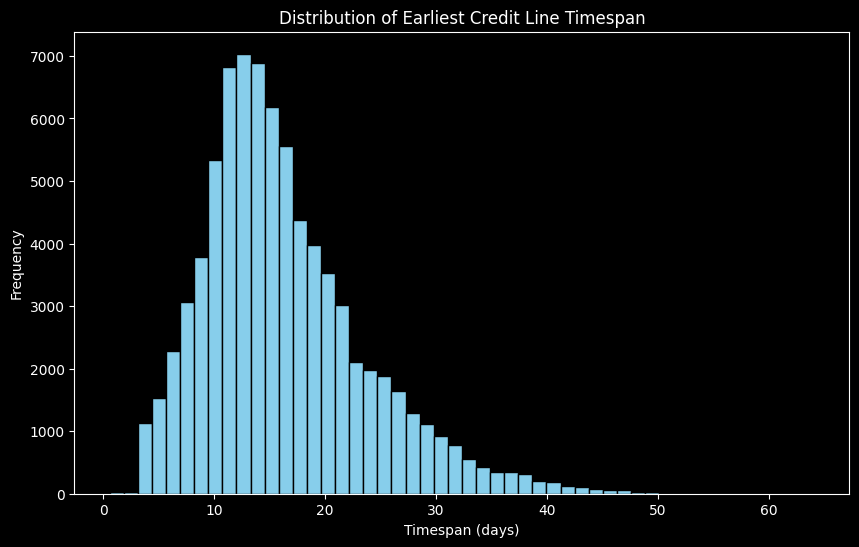

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(df["earliest_cr_line_timespan"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Timespan (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Earliest Credit Line Timespan")
plt.show()

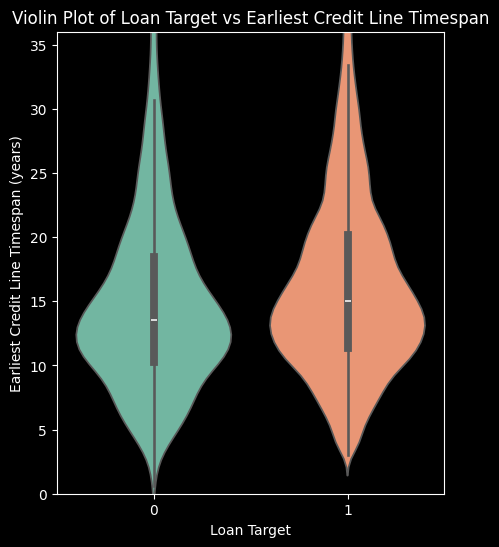

In [38]:
plt.figure(figsize=(5, 6))
sns.violinplot(
    x="loan_target",
    y="earliest_cr_line_timespan",
    data=df,
    hue="loan_target",
    palette="Set2",
    legend=False,
)
plt.ylim(0, 36)
plt.xlabel("Loan Target")
plt.ylabel("Earliest Credit Line Timespan (years)")
plt.title("Violin Plot of Loan Target vs Earliest Credit Line Timespan")
plt.show()

## Lab Model

Split Data

In [39]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(["loan_target"], axis=1)
y = df["loan_target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99
)

Create and train decision tree

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the random forest classifier
clf = RandomForestClassifier(
    random_state=99, n_estimators=300, max_depth=15
)  # , class_weight='balanced')
clf.fit(X_train, y_train)

# Predict on the test data
clf_y_pred = clf.predict(X_test)

Create dummy classifier

In [41]:
from sklearn.dummy import DummyClassifier

# Create and train the dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=99)
dummy_clf.fit(X_train, y_train)

# Predict on the test data
dummy_y_pred = dummy_clf.predict(X_test)

### Classification Report

In [42]:
from sklearn.metrics import classification_report

In [43]:
# Generate the classification report
report = classification_report(
    y_test, clf_y_pred, target_names=["Bad Loans", "Good Loans"]
)
print(report)

              precision    recall  f1-score   support

   Bad Loans       1.00      0.48      0.65      1151
  Good Loans       0.96      1.00      0.98     14698

    accuracy                           0.96     15849
   macro avg       0.98      0.74      0.81     15849
weighted avg       0.96      0.96      0.96     15849



In [44]:
# Evaluate the dummy classifier
dummy_report = classification_report(
    y_test, dummy_y_pred, target_names=["Bad Loans", "Good Loans"], zero_division=0
)
print(dummy_report)

              precision    recall  f1-score   support

   Bad Loans       0.00      0.00      0.00      1151
  Good Loans       0.93      1.00      0.96     14698

    accuracy                           0.93     15849
   macro avg       0.46      0.50      0.48     15849
weighted avg       0.86      0.93      0.89     15849



Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

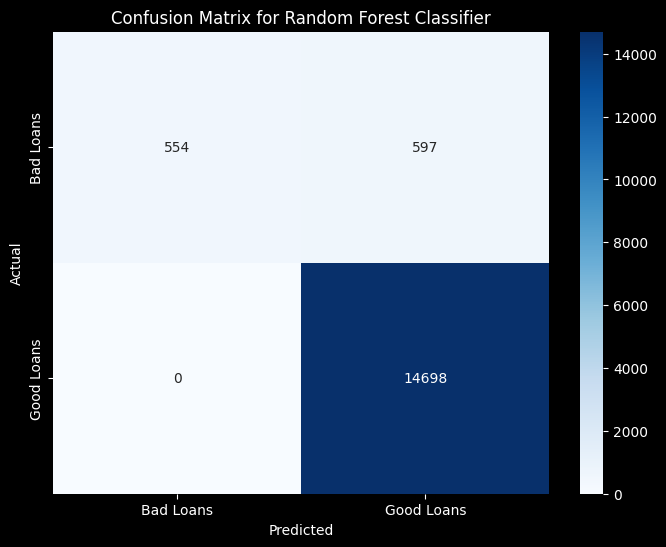

In [ ]:
# Generate the confusion matrix
clf_conf_matrix = confusion_matrix(y_test, clf_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(clf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad Loans", "Good Loans"], yticklabels=["Bad Loans", "Good Loans"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

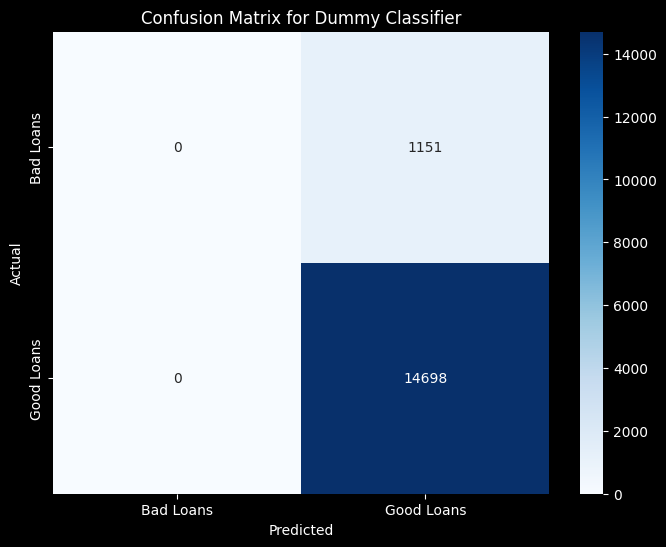

In [48]:
# Generate the confusion matrix for the dummy classifier
dummy_conf_matrix = confusion_matrix(y_test, dummy_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dummy_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad Loans", "Good Loans"], yticklabels=["Bad Loans", "Good Loans"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Dummy Classifier")
plt.show()

List most important features

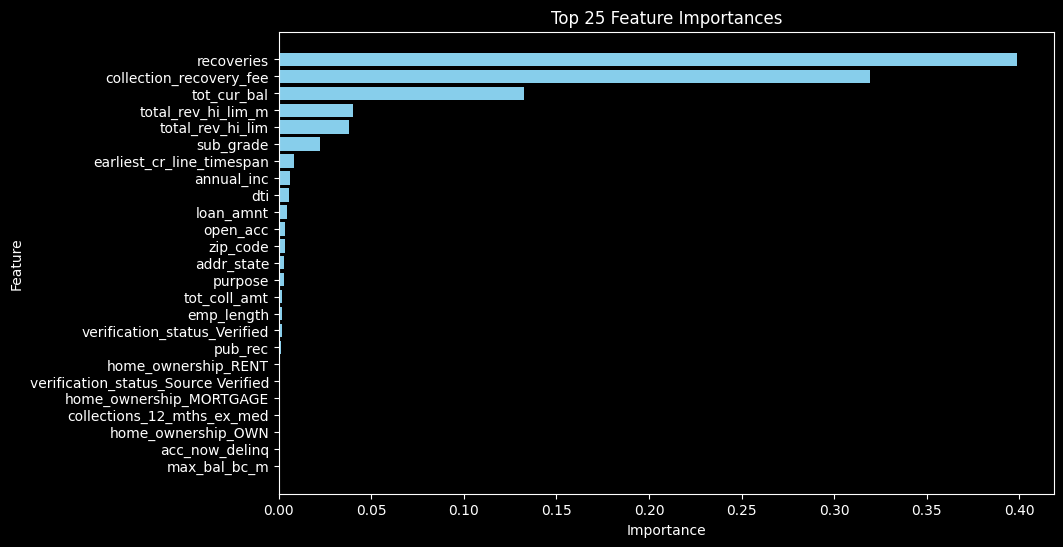

In [766]:
# Get feature importances
clf_importances = clf.feature_importances_
clf_feature_names = X.columns

# Create a DataFrame for visualization
clf_feature_importances = pd.DataFrame({
    "Feature": clf_feature_names,
    "Importance": clf_importances,
})
clf_feature_importances = clf_feature_importances.sort_values(
    by="Importance", ascending=False
).head(25)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    clf_feature_importances["Feature"],
    clf_feature_importances["Importance"],
    color="skyblue",
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 25 Feature Importances")
plt.gca().invert_yaxis()
plt.show()